# Installs

In [1]:
%%capture
#For raw data
!pip install -U sec-edgar-downloader
!pip install beautifulsoup4

# #For embeddings
!pip install tiktoken
!pip install chromadb

# #For LLM Insights
!pip install openai
!pip install langchain
!pip install langchain-openai

# Raw Data Processing

In [2]:
# Setup sec-edgar
from sec_edgar_downloader import Downloader
secdl = Downloader("DelhiTechnologicalUniversity","keshavnath_me20a9_47@dtu.ac.in")

In [3]:
# Download specifics
tickers = ['AAPL']
DOCTYPE = "10-K"
AFTER = "1995-01-01"
BEFORE = "2024-01-01"

In [4]:
# Download 10-K filing
for ticker in tickers:
  secdl.get(DOCTYPE,ticker,after=AFTER,before=BEFORE)

In [5]:
# Text cleaning and singling out the actual 10-K filing

from bs4 import BeautifulSoup
import re

def get_text_content(text_path):
  """
  Extracts textual content from an HTML file using Beautiful Soup, handling various elements.

  Args:
      text_path: Path to SEC-EDGAR .txt file.

  Returns:
      String containing the extracted text content of 10-K Filing.
  """

  html_text=""
  token = "</DOCUMENT>"

  try:
    with open(text_path, 'r') as f:
      # text_content = f.read()
      for line in f:
        html_text += line
        if token in html_text:
          break
  except FileNotFoundError:
    print(f"Error: File not found at {text_path}")
    exit()

  soup = BeautifulSoup(html_text, 'html.parser')

  # Exclude specific tags and attributes
  excluded_tags = ['img', 'script', 'style', 'link', 'object', 'form', 'button', 'td','embed','iframe']
  for tag in excluded_tags:
    for element in soup.find_all(tag):
      element.decompose()  # Remove the entire element

  # Extract text from remaining elements
  text = ''.join(node.string.strip() for node in soup.find_all(string=True))
  return text

In [6]:
res = get_text_content("/content/sec-edgar-filings/AAPL/10-K/0000320193-17-000070/full-submission.txt")

In [7]:
print(len(res))

247929


In [8]:
print(res)

0000320193-17-000070.txt : 201711030000320193-17-000070.hdr.sgml : 2017110320171103080137
ACCESSION NUMBER:		0000320193-17-000070
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		97
CONFORMED PERIOD OF REPORT:	20170930
FILED AS OF DATE:		20171103
DATE AS OF CHANGE:		20171103

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			APPLE INC
		CENTRAL INDEX KEY:			0000320193
		STANDARD INDUSTRIAL CLASSIFICATION:	ELECTRONIC COMPUTERS [3571]
		IRS NUMBER:				942404110
		STATE OF INCORPORATION:			CA
		FISCAL YEAR END:			0930

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-36743
		FILM NUMBER:		171174673

	BUSINESS ADDRESS:	
		STREET 1:		ONE INFINITE LOOP
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014
		BUSINESS PHONE:		(408) 996-1010

	MAIL ADDRESS:	
		STREET 1:		ONE INFINITE LOOP
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014

	FORMER COMPANY:	
		FORMER CONFORMED NAME:	APPLE COMPUTER INC
		DATE OF NAME CHANGE:	1997080810-K1a10-k20179302017.htm10-Khtm

In [9]:
# Create dictionary of year:filing

import os
filings = {}
checkdir = f'./sec-edgar-filings/{tickers[0]}/10-K'
for filename in os.listdir(checkdir):
  filing_folder = os.path.join(checkdir, filename)
  full_path = os.path.join(filing_folder,'full-submission.txt')
  year = filename.split('-')[1]
  year=int(year)
  if (year<=24):
    year+=2000
  else:
    year+=1900
  filings[year]=full_path

for year in sorted(filings.keys()):
  print(f"{year}: {filings[year]}")

1995: ./sec-edgar-filings/AAPL/10-K/0000320193-95-000016/full-submission.txt
1996: ./sec-edgar-filings/AAPL/10-K/0000320193-96-000023/full-submission.txt
1997: ./sec-edgar-filings/AAPL/10-K/0001047469-97-006960/full-submission.txt
1999: ./sec-edgar-filings/AAPL/10-K/0000912057-99-010244/full-submission.txt
2000: ./sec-edgar-filings/AAPL/10-K/0000912057-00-053623/full-submission.txt
2002: ./sec-edgar-filings/AAPL/10-K/0001047469-02-007674/full-submission.txt
2003: ./sec-edgar-filings/AAPL/10-K/0001047469-03-041604/full-submission.txt
2004: ./sec-edgar-filings/AAPL/10-K/0001047469-04-035975/full-submission.txt
2005: ./sec-edgar-filings/AAPL/10-K/0001104659-05-058421/full-submission.txt
2006: ./sec-edgar-filings/AAPL/10-K/0001104659-06-084288/full-submission.txt
2007: ./sec-edgar-filings/AAPL/10-K/0001047469-07-009340/full-submission.txt
2008: ./sec-edgar-filings/AAPL/10-K/0001193125-08-224958/full-submission.txt
2009: ./sec-edgar-filings/AAPL/10-K/0001193125-09-214859/full-submission.txt

#OpenAI Setup

In [10]:
import os
os.environ["OPENAI_API_KEY"] = 'openai_api_key'

In [11]:
from langchain_openai import ChatOpenAI
from langchain.agents import load_tools, initialize_agent, AgentType, tool

chat = ChatOpenAI(temperature=0)

In [12]:
from langchain.cache import InMemoryCache
import langchain
langchain.llm_cache = InMemoryCache()
langchain.chat_cache = InMemoryCache()

In [13]:
# from langchain.memory import ConversationBufferMemory
# memory = ConversationBufferMemory(memory_key='chat_history')

In [14]:
from langchain.prompts import HumanMessagePromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate, AIMessagePromptTemplate
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts.few_shot import FewShotPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

In [15]:
from langchain.document_loaders import TextLoader
from langchain.docstore.document import Document
from langchain.vectorstores import Chroma
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.retrievers.multi_query import MultiQueryRetriever

In [16]:
# import logging
# logging.basicConfig()
# logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

# Document Embedding

In [17]:
!mkdir embeddings

In [19]:
CHUNK_SIZE = 200
MAX_DOCS = 15

In [20]:
# Embedding chunks of all 10-K filings

embedding_function = OpenAIEmbeddings()
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=CHUNK_SIZE)

for year in sorted(filings.keys())[:2]:
  filepath = filings[year]
  clean_text = get_text_content(filepath)
  doc = Document(page_content=clean_text,metadata={"source":"local"})

  docs = text_splitter.split_documents([doc])
  db = Chroma.from_documents(docs, embedding_function, persist_directory=f'./embeddings/{tickers[0]}/{year}')
  db.persist()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


# Prompting and Document Retrieval

In [21]:
actual_prompt = "Can you tell me the differences in company revenue and some other key metrics between the years 1995 and 1996 of this company?"

In [22]:
# Extracting relevant years

pattern = r"\d{4}"
extracted_years = re.findall(pattern, actual_prompt)
extracted_years

['1995', '1996']

In [23]:
# Creating combined context

docs_per_year = MAX_DOCS//len(extracted_years)

relevant_docs = {}

for extracted_year in extracted_years:
  extracted_year=int(extracted_year)
  dbl = Chroma(persist_directory=f'./embeddings/{tickers[0]}/{extracted_year}', embedding_function=embedding_function)
  retriever = dbl.as_retriever()

  search_kwargs = {"k":docs_per_year}
  picked = retriever.get_relevant_documents(actual_prompt,search_kwargs=search_kwargs)

  combined_context = ''.join([pick.page_content for pick in picked])
  relevant_docs[extracted_year] = combined_context

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [24]:
# Pydantic output format

class Insight(BaseModel):
    title: str = Field(description="Title of the insight/metric to be reported (e.g. Net Income, Gross Margin as Percentage of Net Sales etc.)")
    datapoints: List[float] = Field(description="List of numerical (float) data points and correpsonding years (e.g. [10,20,30]) in ascending order of year")
    years: List[str] = Field(description="List of corresponding year for each datapoint (e.g. [2002,2003,2004]) in ascending order")
    unit: str = Field(description="Unit of measurement for the values (e.g. Million USD, Percentage, etc.)")

class ModelOutput(BaseModel):

  insights: List[Insight] = Field(description="List of insights extracted from the given context")
  summary: str = Field(description="Textual summary of the insights (e.g. These figures indicate a decline in revenue, gross margin, net income, and earnings per share from 1995 to 1996, along with an increase in restructuring costs. The company faced challenges in maintaining profitability and operational efficiency during this period.)")

  class Config:
    arbitrary_types_allowed = True

parser = PydanticOutputParser(pydantic_object=ModelOutput)

In [25]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"insights": {"title": "Insights", "description": "List of insights extracted from the given context", "type": "array", "items": {"$ref": "#/definitions/Insight"}}, "summary": {"title": "Summary", "description": "Textual summary of the insights (e.g. These figures indicate a decline in revenue, gross margin, net income, and earnings per share from 1995 to 1996, along with an increase in restructuring costs. The company faced challenges in maintaining profitability and operational efficiency during this period.)", "type":

In [26]:
# Prompt engineering

system_template = "You are an expert at carefully reading and analyzing the SEC 10-K filings of a company. You are able to identify key figures about the company from reading portions of these annual reports."
system_template+= " You make sure to report the correct value, sign and unit for each metric/insight."
system_prompt = SystemMessagePromptTemplate.from_template(system_template)

prompt_template = actual_prompt + "\n"
for extracted_year in relevant_docs.keys():
  prompt_template += f"Content from {extracted_year}:{relevant_docs[extracted_year]}\n\n"

prompt_template+="{instructions}"

human_prompt = HumanMessagePromptTemplate.from_template(prompt_template)

# _ = PromptTemplate(template="{instructions}",
#                    input_variables=[],
#                    partial_variables={"instructions":parser.get_format_instructions()})

# format_instructions = HumanMessagePromptTemplate.from_template(template="{instructions}")

chat_prompt = ChatPromptTemplate.from_messages([system_prompt,
                                                human_prompt]) #Zero shot as of now
request = chat_prompt.format_prompt(instructions=parser.get_format_instructions())

In [27]:
request

ChatPromptValue(messages=[SystemMessage(content='You are an expert at carefully reading and analyzing the SEC 10-K filings of a company. You are able to identify key figures about the company from reading portions of these annual reports. You make sure to report the correct value, sign and unit for each metric/insight.'), HumanMessage(content='Can you tell me the differences in company revenue and some other key metrics between the years 1995 and 1996 of this company?\nContent from 1995:1995                                                                     \n                                                                         \nNet sales                    $ 3,003      $ 2,575     $ 2,652     $ 2,8321995          1994          1993\n                                                                  \nNet sales to unaffiliated customers:\n  North America                        $   6,130     $   5,291     $   4,694Three fiscal years ended                  \nSeptember 29, 1995       

In [28]:
result = chat.invoke(request)
print(result.content)

```json
{
  "insights": [
    {
      "title": "Net Sales",
      "datapoints": [9833, 11062, 9189],
      "years": ["1996", "1995", "1994"],
      "unit": "Million USD"
    },
    {
      "title": "Gross Margin",
      "datapoints": [621, 728, 695],
      "years": ["1996", "1995", "1994"],
      "unit": "Million USD"
    },
    {
      "title": "Net Income",
      "datapoints": [60, 103, 73],
      "years": ["1996", "1995", "1994"],
      "unit": "Million USD"
    },
    {
      "title": "Earnings per Common and Common Equivalent Share",
      "datapoints": [0.48, 0.84, 0.59],
      "years": ["1996", "1995", "1994"],
      "unit": "USD"
    },
    {
      "title": "Restructuring Costs",
      "datapoints": [179, -23, -127],
      "years": ["1996", "1995", "1994"],
      "unit": "Million USD"
    }
  ],
  "summary": "These figures indicate a decline in revenue, gross margin, net income, and earnings per share from 1995 to 1996, along with an increase in restructuring costs. The company

In [32]:
result_object = parser.parse(result.content)
result_object

ModelOutput(insights=[Insight(title='Net Sales', datapoints=[9833.0, 11062.0, 9189.0], years=['1996', '1995', '1994'], unit='Million USD'), Insight(title='Gross Margin', datapoints=[621.0, 728.0, 695.0], years=['1996', '1995', '1994'], unit='Million USD'), Insight(title='Net Income', datapoints=[60.0, 103.0, 73.0], years=['1996', '1995', '1994'], unit='Million USD'), Insight(title='Earnings per Common and Common Equivalent Share', datapoints=[0.48, 0.84, 0.59], years=['1996', '1995', '1994'], unit='USD'), Insight(title='Restructuring Costs', datapoints=[179.0, -23.0, -127.0], years=['1996', '1995', '1994'], unit='Million USD')], summary='These figures indicate a decline in revenue, gross margin, net income, and earnings per share from 1995 to 1996, along with an increase in restructuring costs. The company faced challenges in maintaining profitability and operational efficiency during this period.')

In [55]:
import matplotlib.pyplot as plt

def plotter(result_object):

  print(result_object.summary+"\n")

  for insight in result_object.insights:
    title = str(insight.title)
    unit = str(insight.unit)
    datapoints = insight.datapoints
    years = insight.years

    plt.figure(figsize=(8, 5))  # Set plot size
    plt.bar(years, datapoints)
    plt.plot(years, datapoints, marker='o', color='green')  # Line plot
    for year, datapoint in zip(years,datapoints):
      plt.text(year, datapoint, f"{datapoint} {unit}", ha='center', va='bottom', fontsize=8)
    plt.xlabel("Year")
    plt.ylabel(f"{title} ({unit})")  # Label axes with title and unit
    plt.title(f"{title} in {', '.join(years)}")  # Set plot title
    plt.grid(True)  # Add grid lines
    plt.show()  # Display the plot

These figures indicate a decline in revenue, gross margin, net income, and earnings per share from 1995 to 1996, along with an increase in restructuring costs. The company faced challenges in maintaining profitability and operational efficiency during this period.



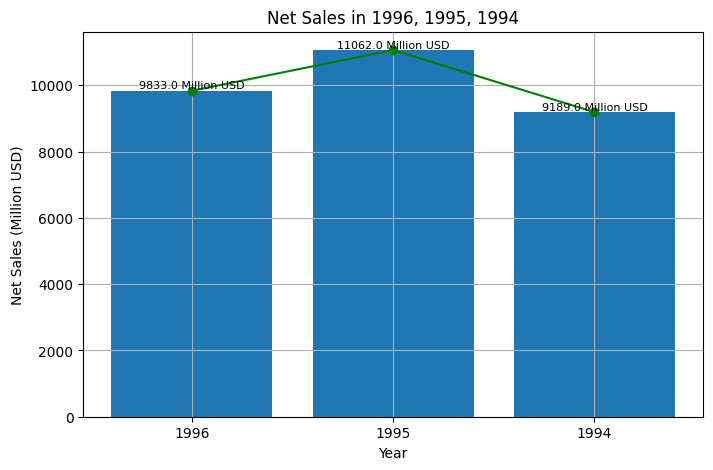

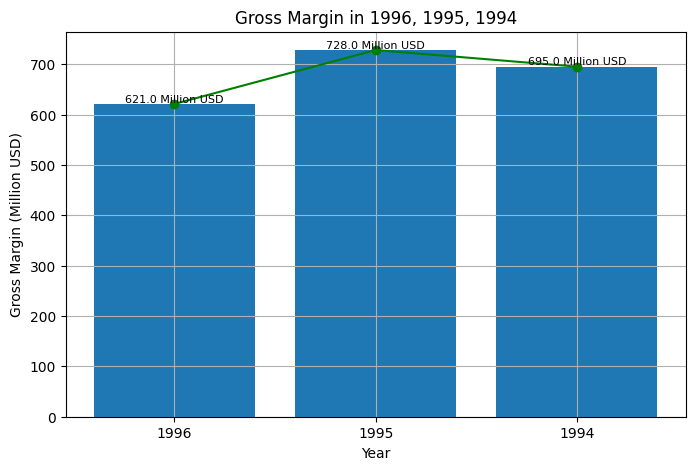

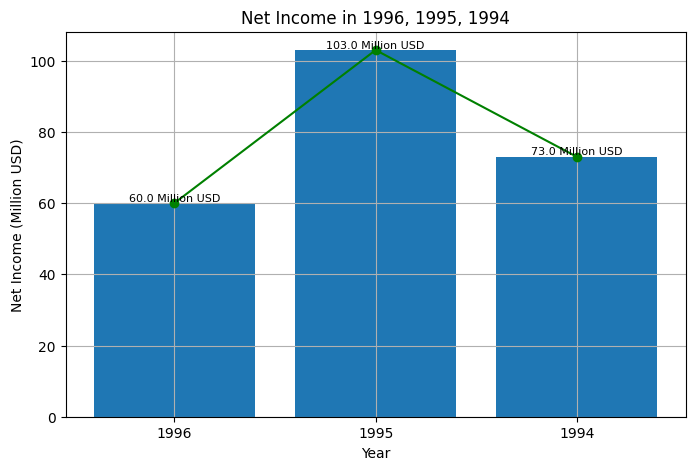

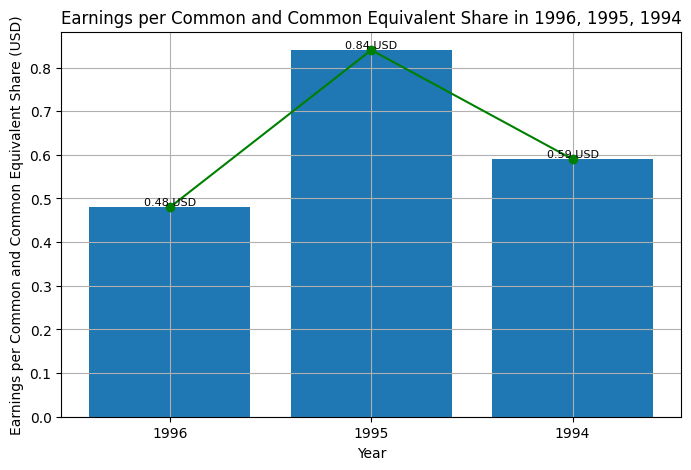

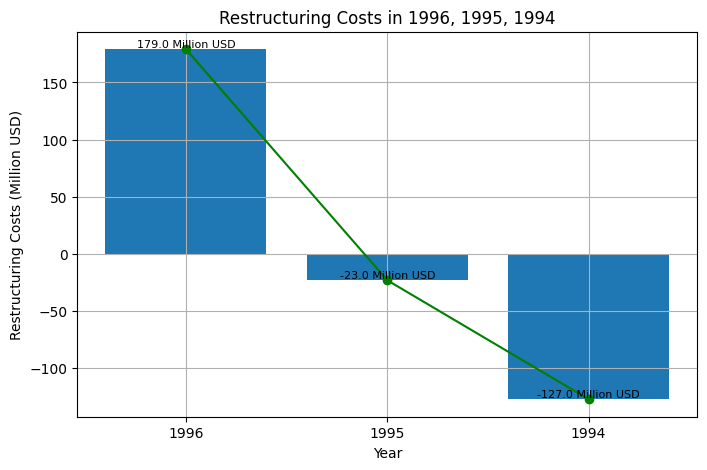

In [56]:
plotter(result_object)